## Working with Sample Heat and Health Data pt. 2
### Regenerating Synthetic Health Data and Tuning the Lambda Parameter

Last week, I created a dataset which includes daily Tmax readings and Death counts from a single station. These death counts were manually entered by me based on intuition and knowledge that the exposure-response curve should have a J- or U-shape. We then explored fitting that data to a GAM using default settings. That data set and analysis is shown and recapped below:

Date,Station,Tmax,Deaths,Year
1/1/1989,USC00445300,42.08,21,1989
2/1/1989,USC00445300,75.02,11,1989
3/1/1989,USC00445300,53.96,25,1989
4/1/1989,USC00445300,51.98,26,1989
5/1/1989,USC00445300,75.02,14,1989
6/1/1989,USC00445300,93.92,40,1989



Family: gaussian 
Link function: identity 

Formula:
Deaths ~ s(Tmax) + s(Year)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  24.6478     0.2787   88.43   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
          edf Ref.df      F  p-value    
s(Tmax) 8.056  8.760 70.878  < 2e-16 ***
s(Year) 7.964  8.713  3.271 0.000624 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

R-sq.(adj) =  0.672   Deviance explained = 68.8%
GCV = 26.101  Scale est. = 24.704    n = 318

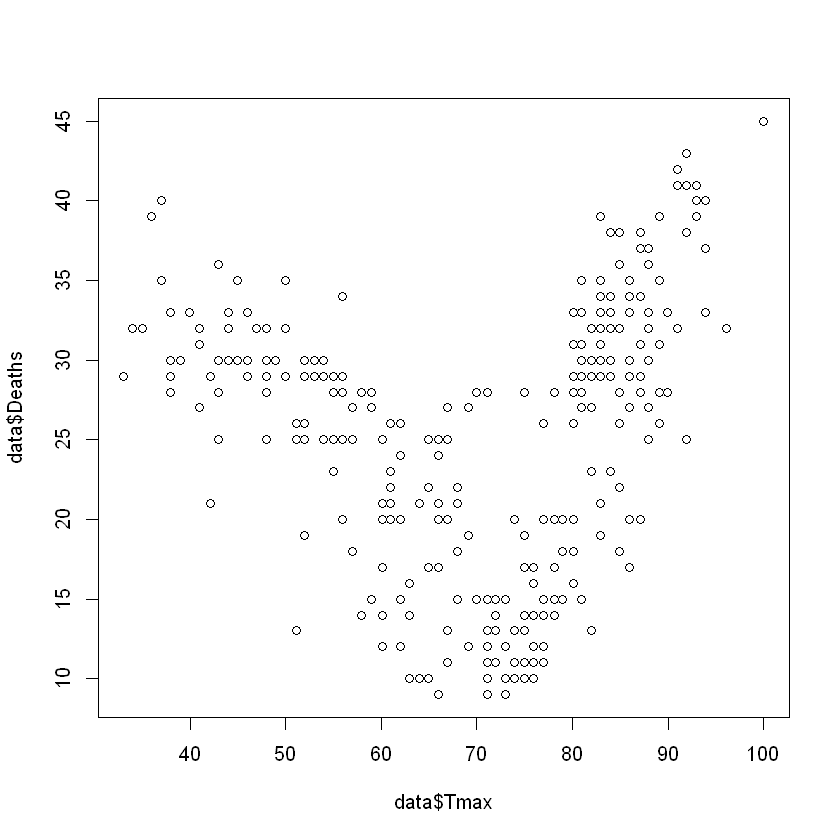

In [9]:
# this data shows the date, tmax, and my manually created "death count" for a particular station in VA
data <- read.csv(file="tmax_data.csv", header=TRUE, sep=",")
require(stringr)
data$Year <- str_sub(data$Date,-4,-1)
data$Year <- sapply(data['Year'], as.numeric)
head(data)
plot(data$Tmax, data$Deaths)
require(mgcv)
m <- gam(Deaths ~ s(Tmax) + s(Year), data=data)
summary(m)


Call:
glm(formula = Deaths ~ Tmax + I(Tmax^2), family = "poisson", 
    data = parabola)

Deviance Residuals: 
      1        2        3        4        5  
 0.1009  -0.2094  -0.4168   0.6462  -0.1752  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  7.2020024  0.7267425   9.910  < 2e-16 ***
Tmax        -0.1555626  0.0276874  -5.619 1.93e-08 ***
I(Tmax^2)    0.0012642  0.0002195   5.758 8.49e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 37.72738  on 4  degrees of freedom
Residual deviance:  0.67601  on 2  degrees of freedom
AIC: 31.411

Number of Fisher Scoring iterations: 4


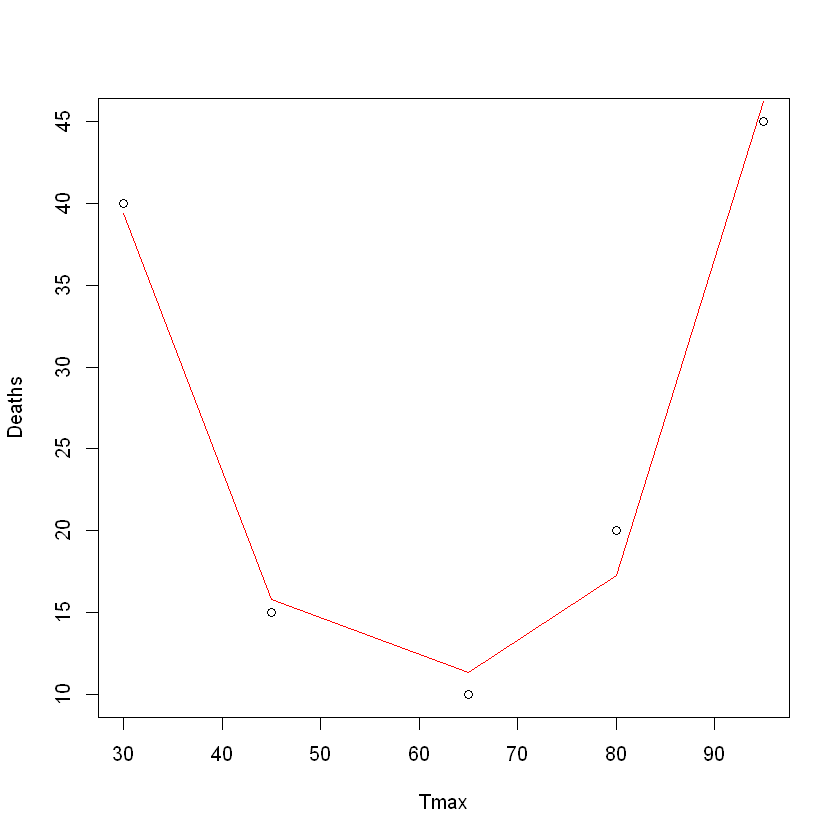

In [28]:
# I made a few date points here that represent x,y coordinates of a parabola 
# basic representative of what the exposure response curve should look like
# I modeled this and then used the model formula to generate deaths
parabola <- data.frame("Tmax" = c(30, 45, 65, 80, 95), "Deaths" = c(40, 15, 10, 20, 45))
m2 <- glm(Deaths~Tmax + I(Tmax^2), data=parabola, family="poisson")
summary(m2)
plot(parabola)
lines(fitted(m2) ~ Tmax, data = parabola, col = "red")


In [25]:
data$gen_deaths <- predict(m2, data, type="response")
head(data)

ERROR: Error in eval(predvars, data, env): object 'RH' not found


In [14]:
# Another way to generate Poisson distributed data of Tmax and Deaths
n <- 318
beta0 <- 7.2020024
beta1 <- -0.1555626
beta2 <- 0.0012642
beta3 <- 0.0307596
tmax <- runif(n=n, min=30, max=93)
mu <- exp(beta0 + beta1 * tmax + beta2 * I(tmax^2) + beta3*rh)
deaths <- rpois(n=n, lambda=mu)
gen_data <- data.frame(tmax=tmax, deaths=deaths)
nrow(gen_data)
head(gen_data)

[1] 318

tmax,deaths
49.56255,21
90.86961,27
43.17068,13
89.39959,15
65.94606,6
76.53674,17


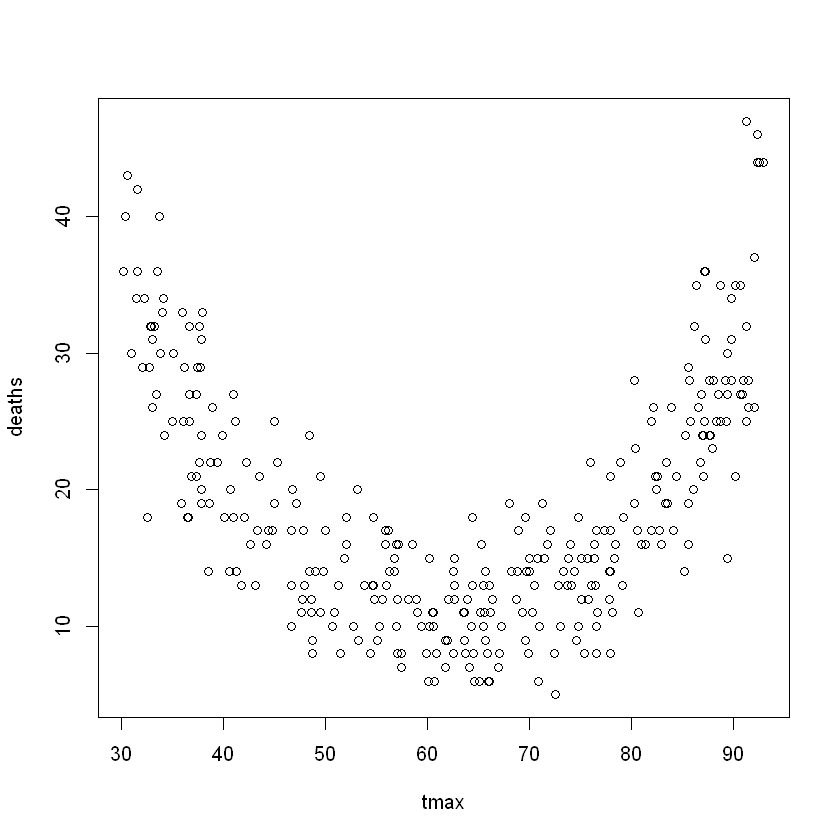

In [15]:
plot(gen_data)

In [ ]:
# fit synthetic data to a GAM
m3 <- gam(deaths ~ s(tmax), data=gen_data)
summary(m3)

In [ ]:
# current lambda
m3$sp


In [ ]:
# find the optimal lambda
require(MASS)
#rgmod <- lm.ridge(deaths ~ ., gen_data, lambda = seq(0, 5e-8, len=21))
rgmod <- lm.ridge(Deaths ~ Tmax + Year, data, lambda = seq(0, 5e-8, len=21))
#data(meatspec, package="faraway")
#meatspec[1:172,]
#rgmod <- lm.ridge(fat ~ ., trainmeat, lambda = seq(0, 5e-8, len=21))

matplot(rgmod$lambda, coef(rgmod), type="l", xlab=expression(lambda), ylab=expression(hat(beta)), col=1)